In [222]:
import obspy
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from scatseisnet import ScatteringNetwork
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import dates as mdates
import sklearn.decomposition
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, DBSCAN
import umap
from tqdm.auto import tqdm


# Toy example


Playing with tutorial : https://scatseisnet.readthedocs.io/en/latest/tutorials/0_intro.html


In [70]:
# Connect to the IRIS datacenter
client = Client("GFZ")

# Collect waveforms from the datacenter
stream = client.get_waveforms(
    network="X9",
    station="SV13",
    location="*",
    channel="*",
    starttime=UTCDateTime("2015-12-04T00:00"),
    endtime=UTCDateTime("2015-12-05T00:00"),
)

3 Trace(s) in Stream:
X9.SV13..HHE | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples
X9.SV13..HHN | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples
X9.SV13..HHZ | 2015-12-04T00:00:00.000000Z - 2015-12-05T00:00:00.000000Z | 50.0 Hz, 4320001 samples


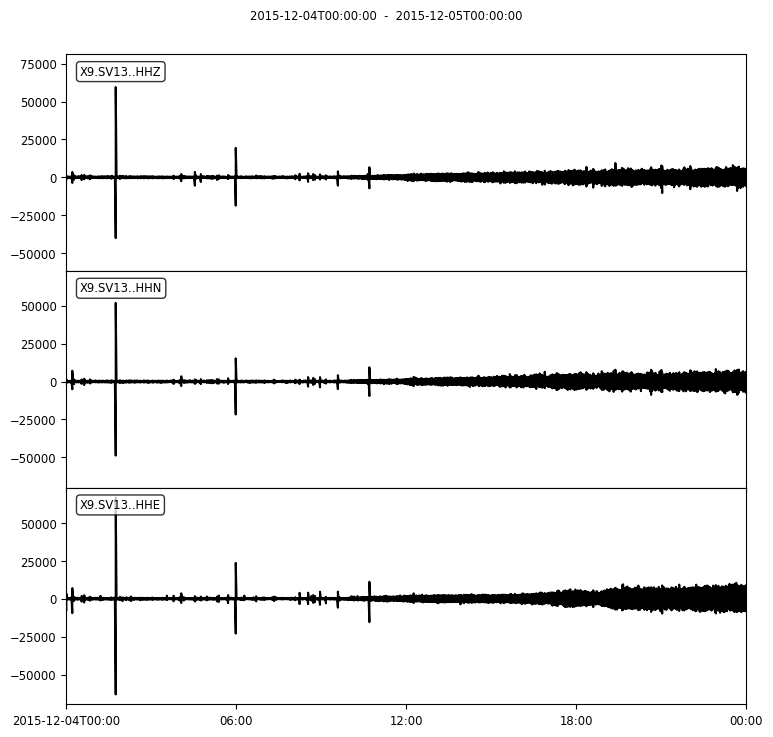

/Users/rohan/miniconda3/envs/advent_of_code/lib/python3.9/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [71]:
# this depends on the specific data we have
stream.merge(method=1)
stream.detrend("linear")
stream.filter(type="highpass", freq=1.0)
print(stream)
stream.plot(rasterized=True)
# channels: Z N, E,: Vertical motion, horizontal (north-south), horizontal (east-west)

# save the stream data for the other notebooks
stream.write("../data/misc/scattering_stream.mseed", format="MSEED")

In [95]:
segment_duration_seconds = 40.0
sampling_rate_hertz = 50.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 6, "resolution": 4, "quality": 2},
    {"octaves": 6, "resolution": 1, "quality": 2},
)

In [96]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=2000, sampling_rate=50.0, len=2)
ComplexMorletBank(bins=2000, octaves=6, resolution=4, quality=2, sampling_rate=50.0, len=24)
ComplexMorletBank(bins=2000, octaves=6, resolution=1, quality=2, sampling_rate=50.0, len=6)


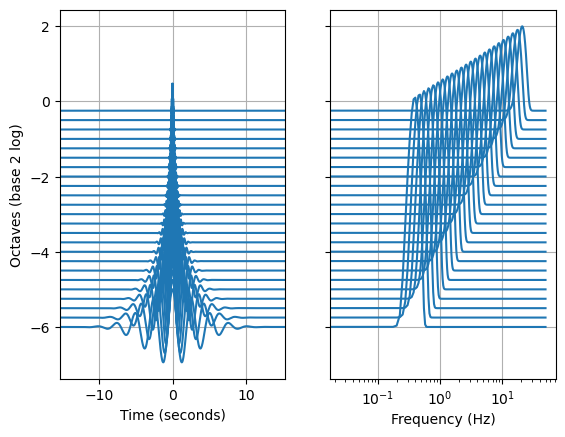

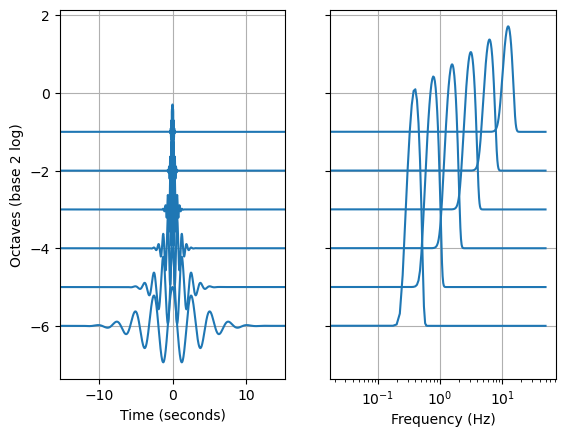

In [97]:
# Loop over network layers
for bank in network.banks:
    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(bank.wavelets, bank.spectra, bank.ratios):
        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[0].grid()
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].grid()

In [98]:
# Extract segment length (from any layer)
segment_duration_seconds = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(
    segment_duration_seconds, segment_duration_seconds * overlap
):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

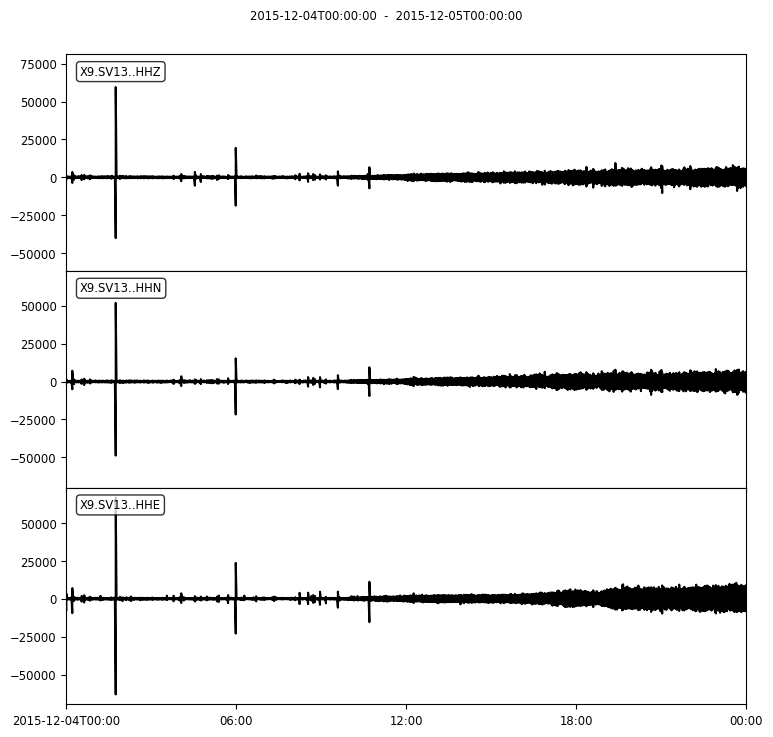

In [101]:
stream.plot()
plt.show()

In [99]:
print(len(segments), segment_duration_seconds)
segments[0].shape

4319 40.0


(3, 2000)

In [8]:
scattering_coefficients = network.transform(segments, reduce_type=np.median)


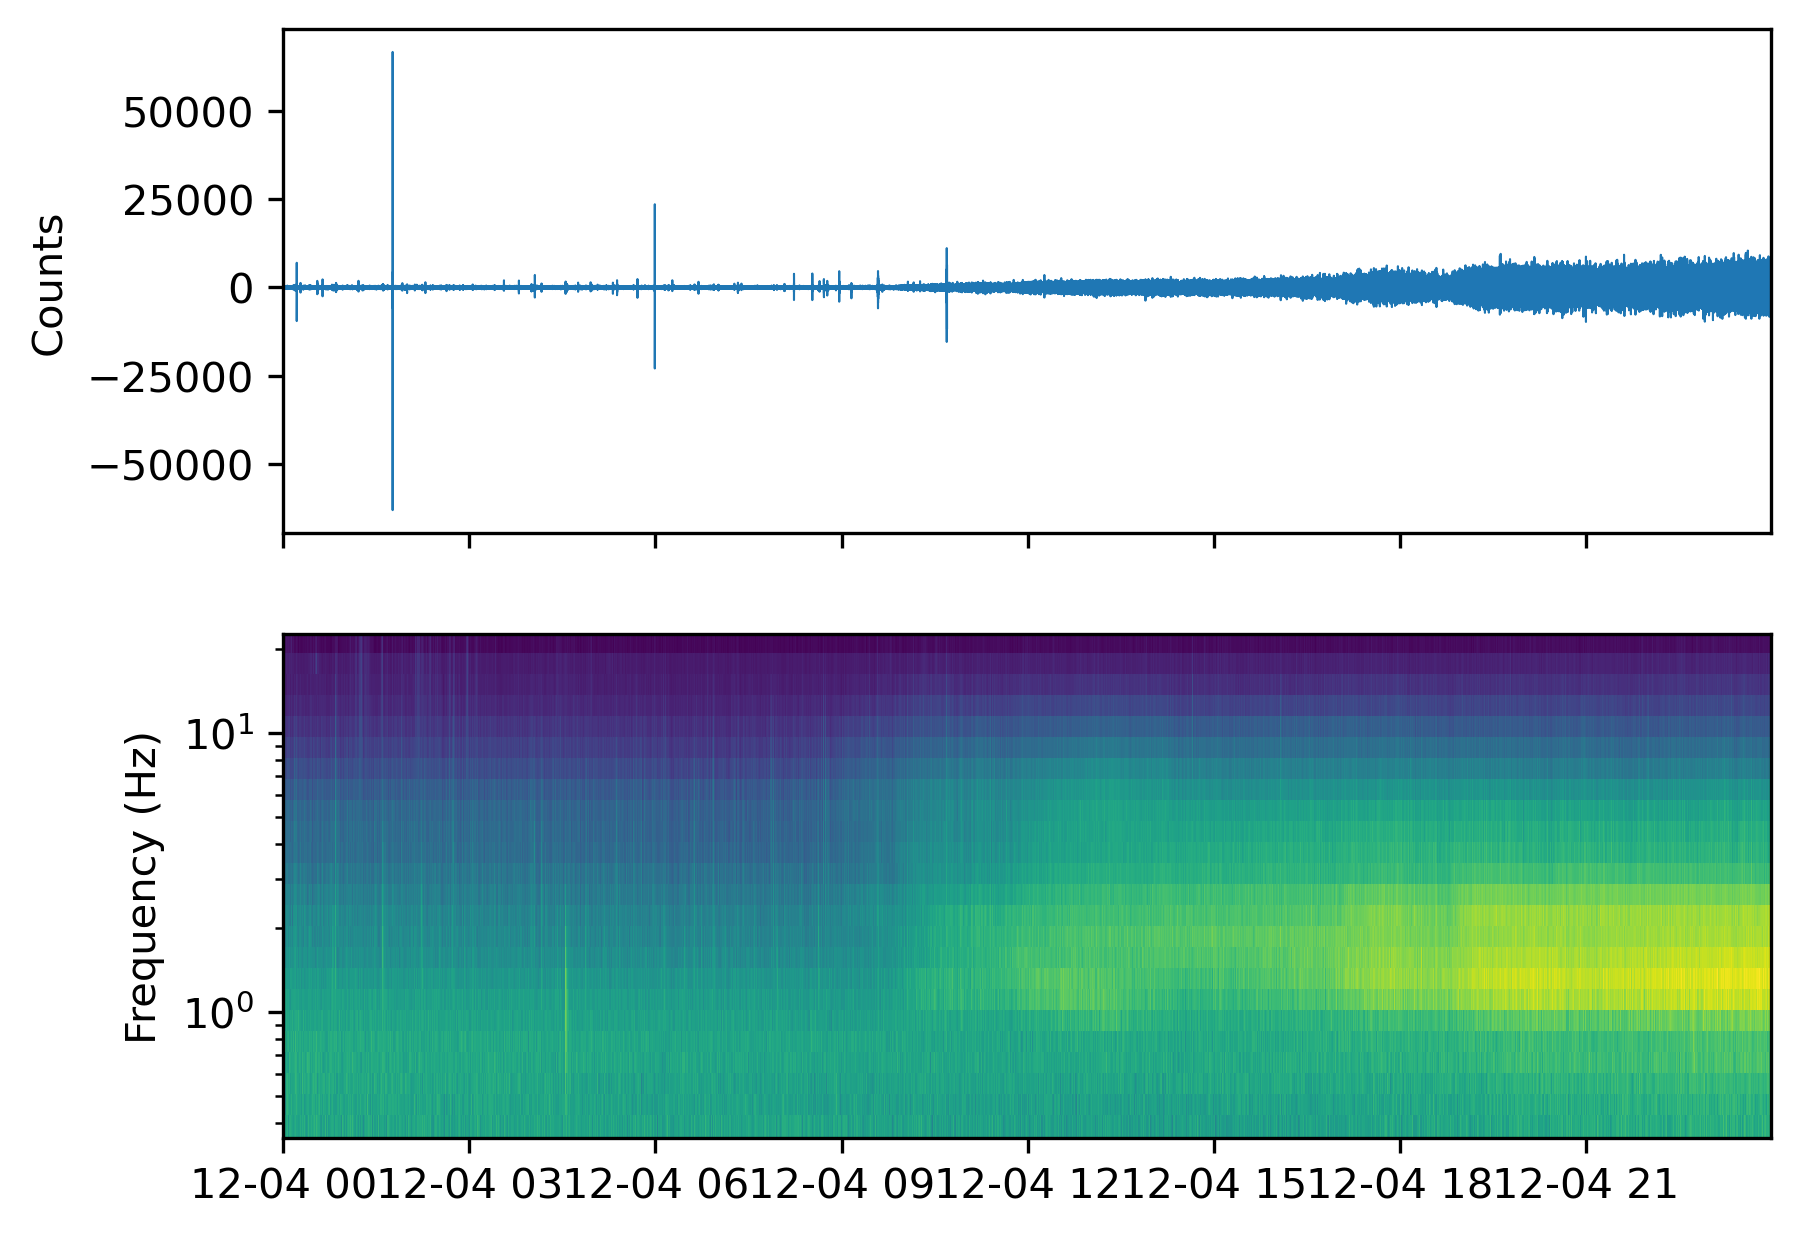

In [11]:
# Extract the first channel
channel_id = 0
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True, dpi=300)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# First-order scattering coefficients
ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# Axes labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")

# Show
plt.show()

In [15]:
order_1 = scattering_coefficients[0]
order_2 = scattering_coefficients[1]
times = timestamps
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log10(scattering_coefficients)


In [20]:
times = np.array(times)

In [16]:
# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 4319 samples of 504 dimensions each.


In [18]:
# play with n_components, see if features have structure?
pca_model = PCA(n_components=10, whiten=True)
pca_features = pca_model.fit_transform(scattering_coefficients)

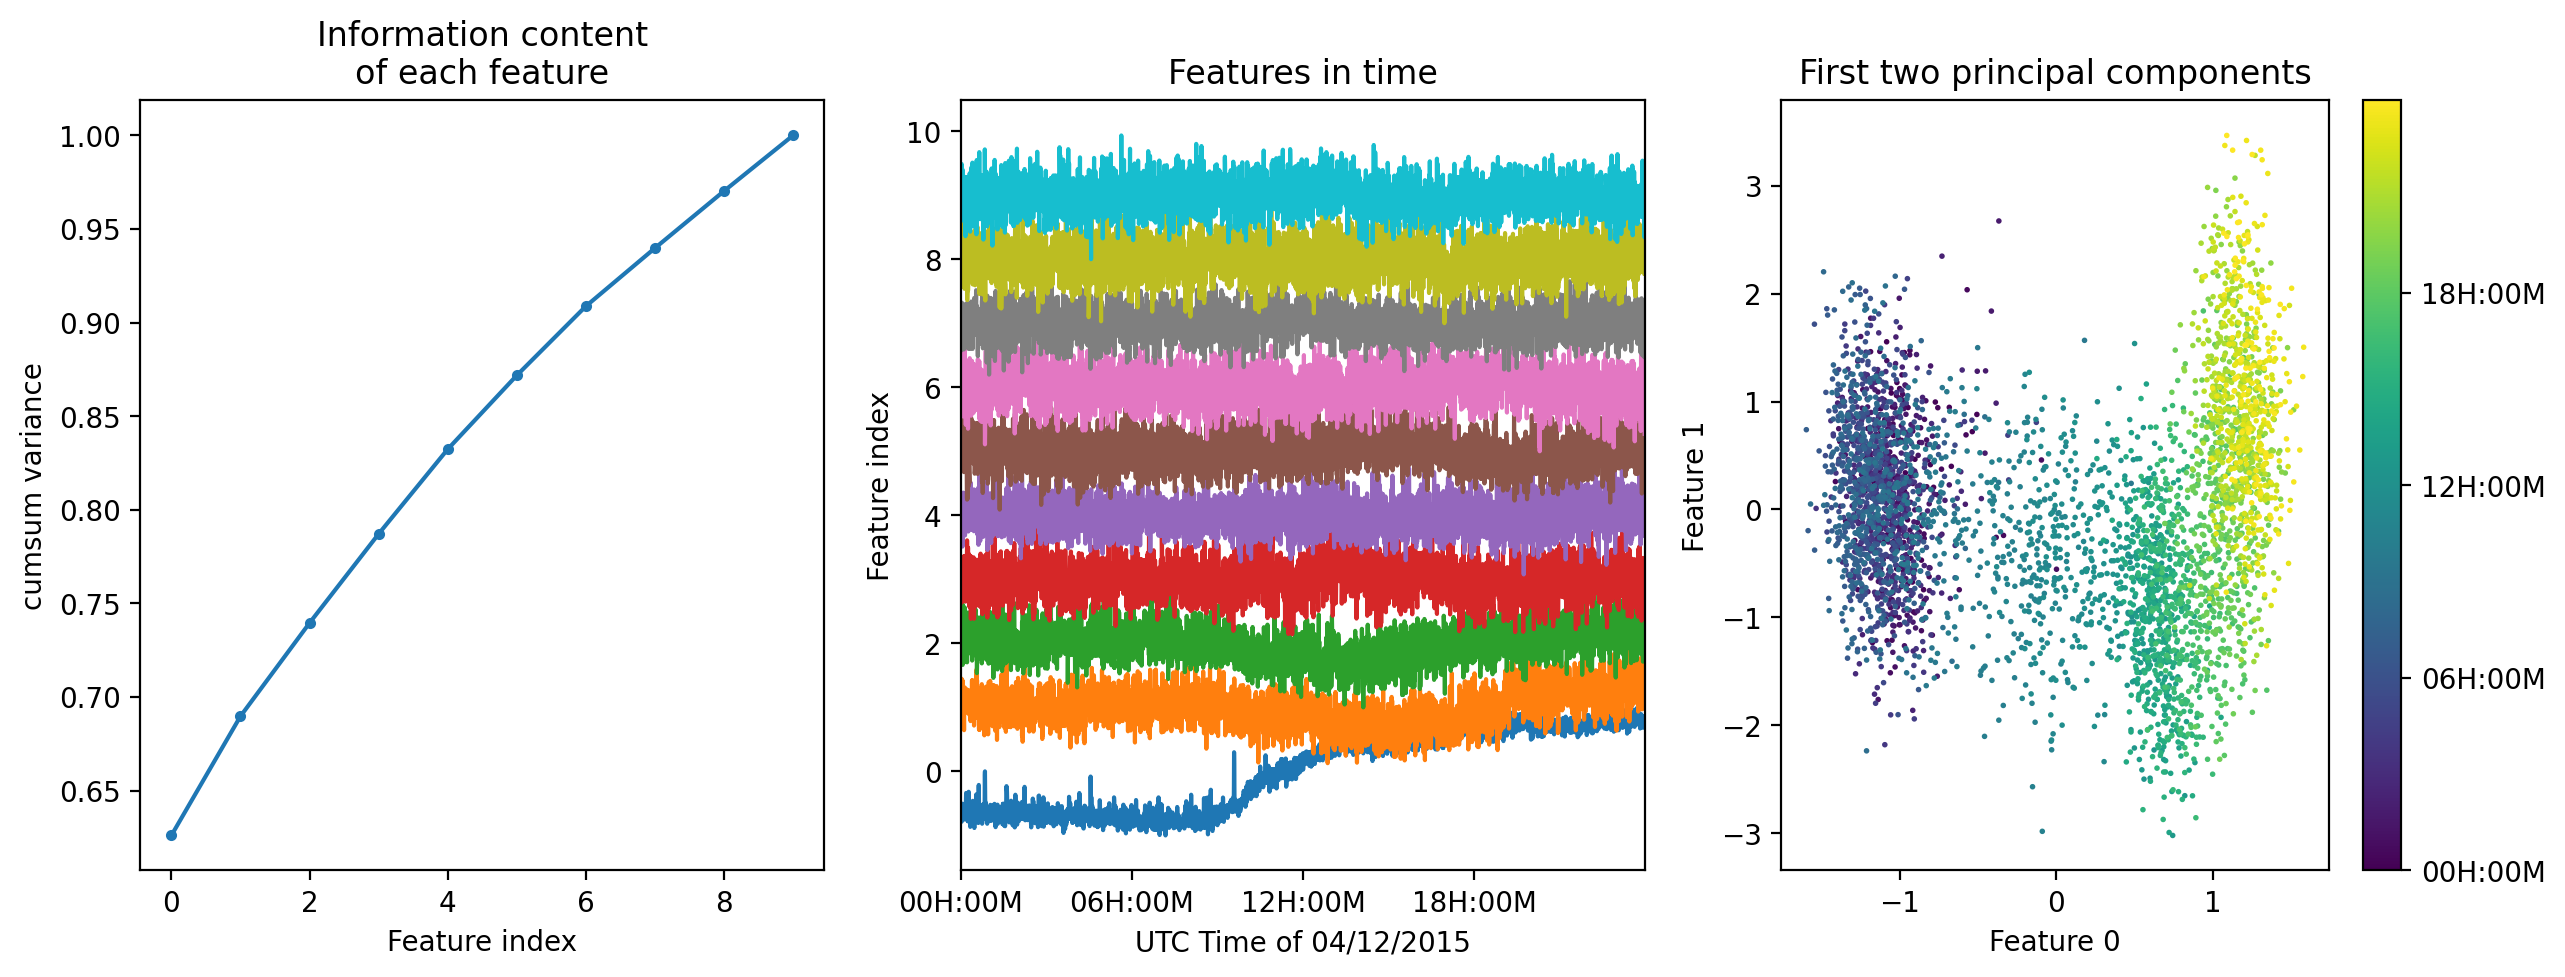

In [21]:
# Normalize features for display
features_normalized = pca_features / np.abs(pca_features).max(axis=0)
myFmt = mdates.DateFormatter("%HH:%MM")

# Figure and axes instance
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

# Plot the cumulative sum of the explained variance ratio of the principal components
axes[0].plot(
    np.cumsum(
        pca_model.explained_variance_ratio_ / sum(pca_model.explained_variance_ratio_)
    ),
    ".-",
)
axes[0].set_ylabel("cumsum variance")
axes[0].set_xlabel("Feature index")
axes[0].set_title("Information content\nof each feature")

# Plot features in time
axes[1].plot(
    times,
    features_normalized + np.arange(features_normalized.shape[1]),
    rasterized=True,
)
axes[1].set_xlim(times.min(), times.max())
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
axes[1].set_ylabel("Feature index")
axes[1].set_xlabel("UTC Time of 04/12/2015")
axes[1].set_title("Features in time")


# Plot the first two principal components
mappable = axes[2].scatter(
    pca_features[:, 0], pca_features[:, 1], s=1, c=mdates.date2num(times)
)
axes[2].set_ylabel("Feature 1")
axes[2].set_xlabel("Feature 0")
axes[2].set_title("First two principal components")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(), times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))

# Show
plt.show()

The time history of feature 0 seems to reflect the time history of the tremor signal in the seismogram.

In the third plot, we color the first two principal components by time. There is a cluster corresponding to a later point in time, where the tremor signal originally appeared.


In [22]:
ica_model = FastICA(n_components=4, whiten="unit-variance", random_state=42)
ica_features = ica_model.fit_transform(scattering_coefficients)

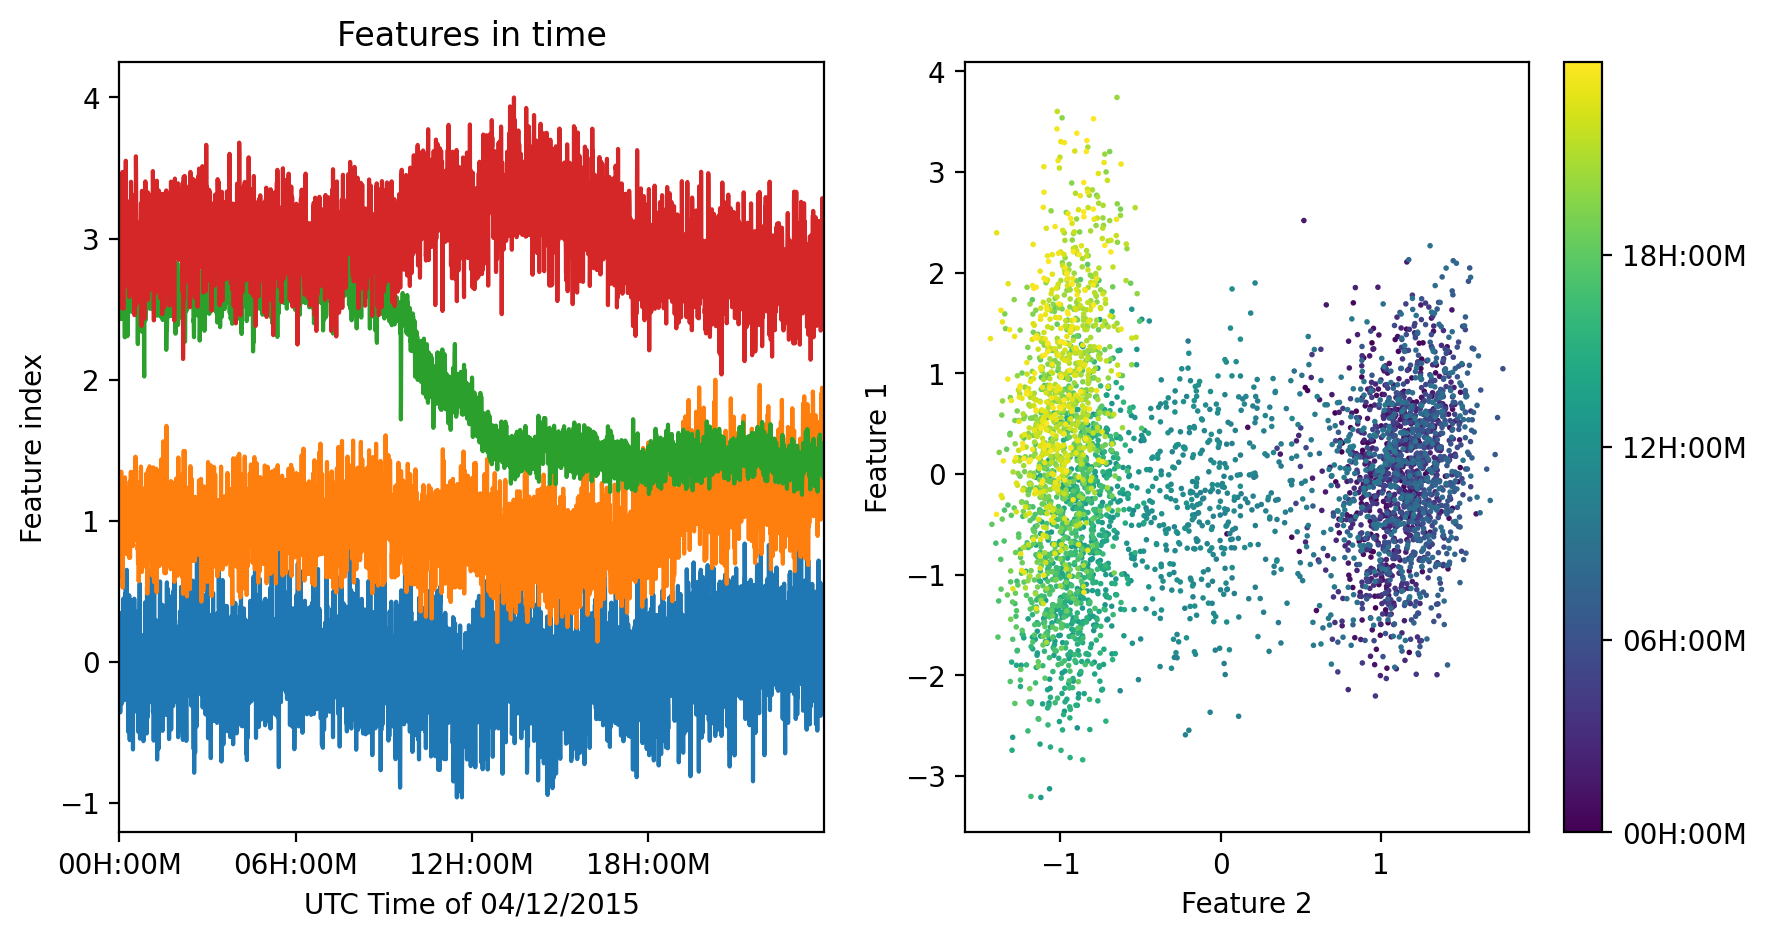

In [23]:
# Normalize features for display
features_normalized = ica_features / np.abs(ica_features).max(axis=0)
myFmt = mdates.DateFormatter("%HH:%MM")

# Figure and axes instance
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

# Plot features in time
axes[0].plot(
    times, features_normalized + np.arange(ica_features.shape[1]), rasterized=True
)
axes[0].set_xlim(times.min(), times.max())
axes[0].xaxis.set_major_formatter(myFmt)
axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=6))
axes[0].set_ylabel("Feature index")
axes[0].set_xlabel("UTC Time of 04/12/2015")
axes[0].set_title("Features in time")


# Plot the first two principal components
mappable = axes[1].scatter(
    ica_features[:, 2], ica_features[:, 1], s=1, c=mdates.date2num(times)
)
axes[1].set_ylabel("Feature 1")
axes[1].set_xlabel("Feature 2")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(), times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))

# Show
plt.show()

In [24]:
features = ica_features

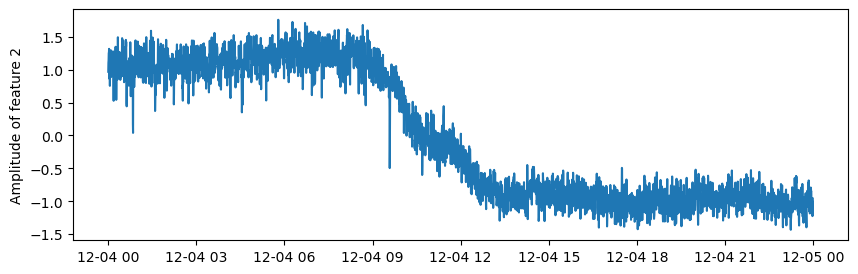

In [26]:
# sign of the feature doesnt matter, its only relative change
feature_id = 2
feature = features[:, feature_id]

# Figure creation
fig = plt.figure(figsize=(10, 3))
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

In [28]:
N_CLUSTERS = 4

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=4)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

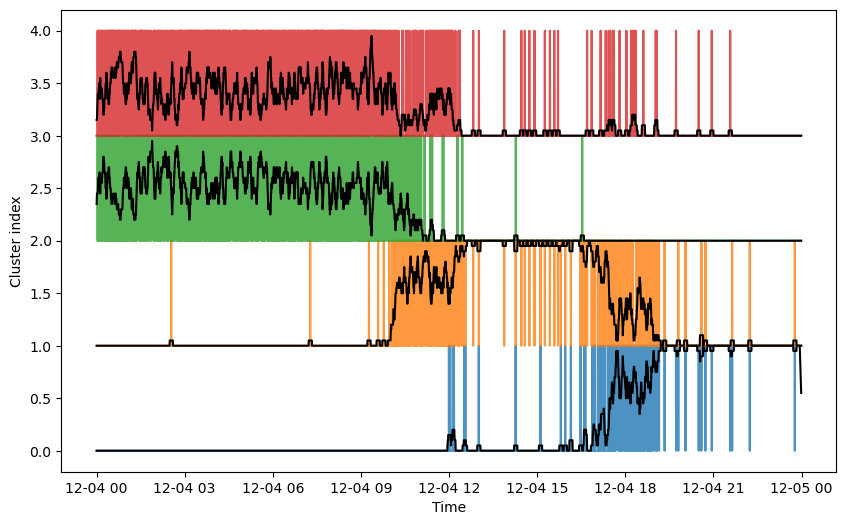

In [29]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):
    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = (
        np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
    )

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.8)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()


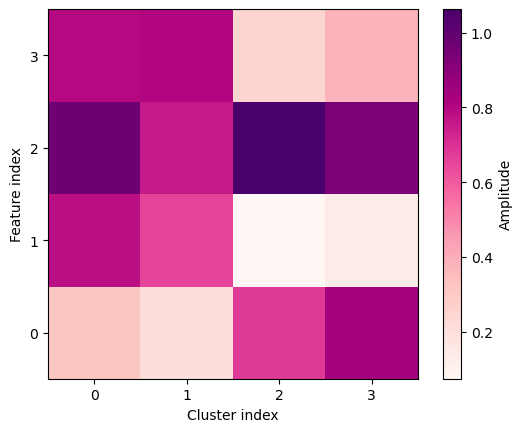

In [30]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure()
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show()

In [33]:
N_WAVEFORMS = 5

# Read the stream
stream = obspy.read("../data/misc/scattering_stream.mseed").select(channel="HHE")
waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):
    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:5]]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy()
        traces.append(trace)
    waveforms.append(traces)

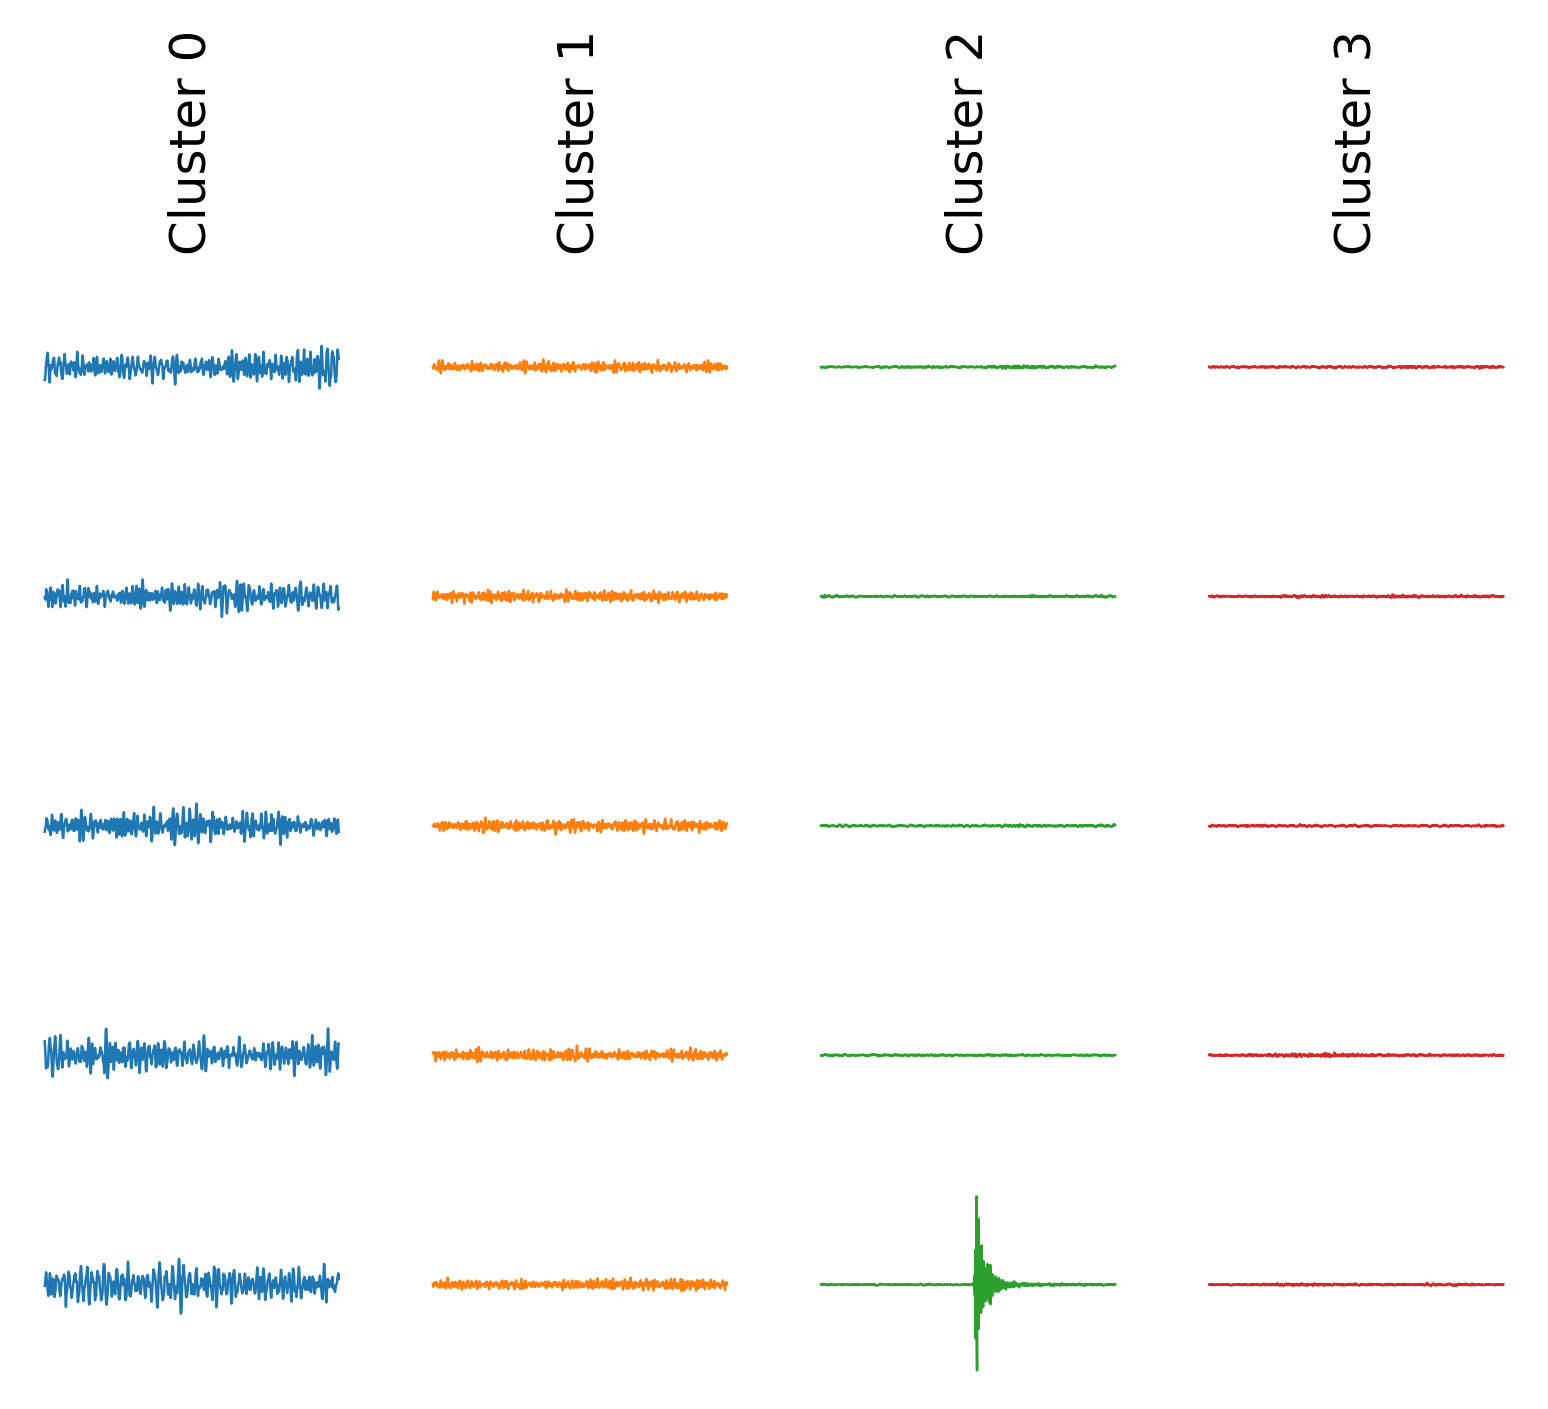

In [34]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=300)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show()

/Users/rohan/miniconda3/envs/advent_of_code/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


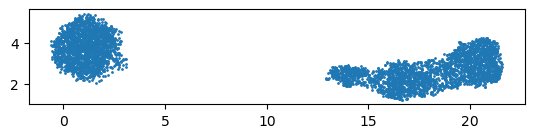

In [37]:
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding = umap_model.fit_transform(scattering_coefficients)

# Visualize the UMAP results
fig, ax = plt.subplots()
ax.scatter(embedding[:, 0], embedding[:, 1], s=1)
ax.set_aspect("equal")

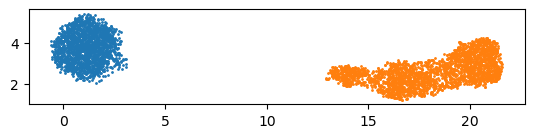

In [38]:
# clustering task
N_CLUSTERS = 2
cluster_model = KMeans(n_clusters=N_CLUSTERS)
predictions = cluster_model.fit_predict(embedding)

# show clustering results in the atlas
fig, ax = plt.subplots()
for label in np.unique(predictions):
    where = label == predictions
    ax.scatter(embedding[where, 0], embedding[where, 1], s=1)
ax.set_aspect("equal")

# Lunar dataset exploration


In [223]:
from pathlib import Path
import pandas as pd


In [224]:
base_dir = Path("../data/space_apps_2024_seismic_detection")
cat_file = base_dir / "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
cat = pd.read_csv(cat_file)
# for convenient access
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]

train_dir = base_dir / "data/lunar/training/data/"
test_dir = base_dir / "data/lunar/test/data/"

# get from df so we can match with arrival times
train_filenames = [train_dir / f"S12_GradeA/{x}.mseed" for x in cat.filename]
test_filenames = list(test_dir.rglob("*.mseed"))

print("training data: ", len(list(train_dir.rglob("*.mseed"))))
print("test data: ", len(test_filenames))

for i, f in enumerate(train_filenames):
    if "evid00029" in str(f):
        train_filenames[i] = Path(
            "../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed"
        )
train_streams = []
for f in train_filenames:
    try:
        train_streams.append(obspy.read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

test_streams = []
for f in test_filenames:
    try:
        test_streams.append(obspy.read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

training data:  76
test data:  96


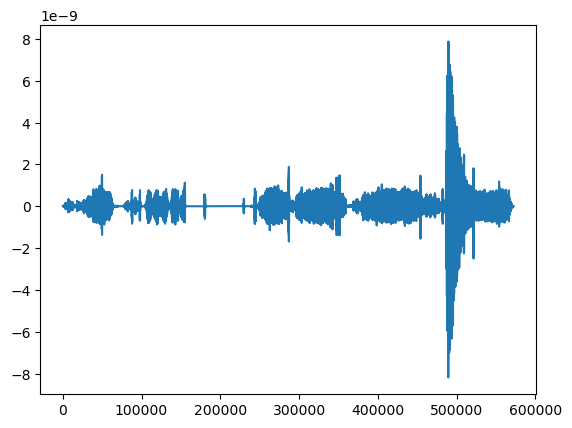

In [225]:
stream = train_streams[0]
plt.plot(stream[0].data)
plt.show()

## flag the error parts


  0%|          | 0/172 [00:00<?, ?it/s]

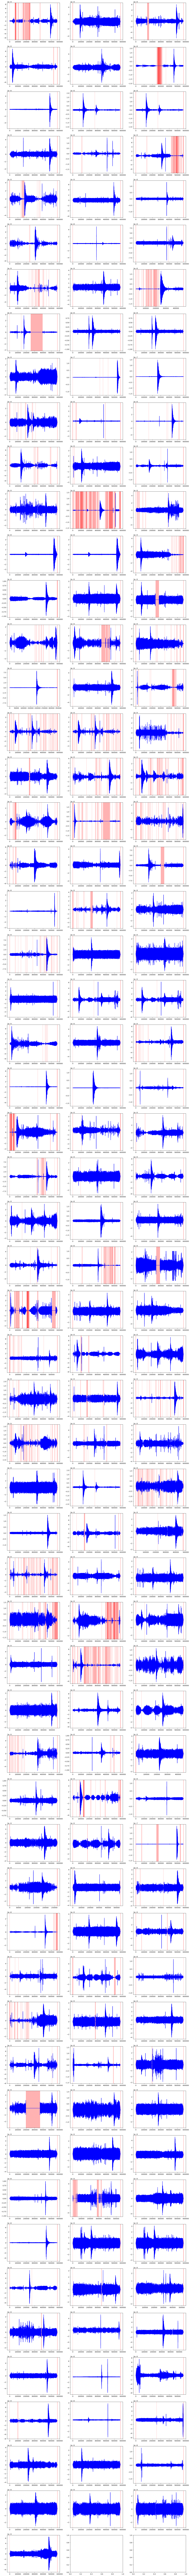

In [228]:
def calculate_sta(time_series, sta_length):
    # efficient way to calculate STA (thanks chatgpt)
    sta = np.zeros(len(time_series))
    cumsum = np.cumsum(np.insert(time_series, 0, 0))
    sta[sta_length:] = (
        cumsum[sta_length + 1 :] - cumsum[: -sta_length - 1]
    ) / sta_length
    return sta


def identify_low_sta_periods(sta, threshold=1e-14, min_period_length=50):
    low_sta_mask = np.abs(sta) < threshold
    low_sta_periods = []
    start = None
    for i, is_low in enumerate(low_sta_mask):
        if is_low and start is None:
            start = i
        elif not is_low and start is not None:
            if i - start >= min_period_length:
                low_sta_periods.append((start, i))
            start = None
    if start is not None and len(sta) - start >= min_period_length:
        low_sta_periods.append((start, len(sta)))
    return low_sta_periods


def remove_low_sta_periods(stream, low_sta_periods):
    data = stream[0].data
    times = stream[0].times()
    mask = np.ones(len(data), dtype=bool)
    for start, end in low_sta_periods:
        mask[start:end] = False
    return data[mask], times[mask]


# Calculate the number of rows and columns for the grid
all_streams = train_streams + test_streams
n_streams = len(all_streams)


# plotting stuff
n_cols = 3
n_rows = (n_streams + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

cleaned_streams = []

for i, stream in tqdm(enumerate(all_streams), total=len(all_streams)):
    if i < len(axes):
        data = stream[0].data
        times = stream[0].times()
        x = np.arange(len(data))
        sta = calculate_sta(data, 100)
        low_sta_periods = identify_low_sta_periods(sta)

        # Remove low STA periods and store in new array
        cleaned_data, cleaned_time = remove_low_sta_periods(stream, low_sta_periods)
        cleaned_streams.append((cleaned_time, cleaned_data))
        #         # uncomment to plot (3min+)
        ax = axes[i]
        ax.plot(x, data, c="blue", label="Original Data")
        # ax.plot(
        #     np.arange(len(cleaned_data)), cleaned_data, c="green", label="Cleaned Data"
        # )
        for start, end in low_sta_periods:
            ax.axvspan(start, end, color="red", alpha=0.3)

#         ax.set_title(f"Stream {i+1}")
#         ax.set_xlabel("Sample")
#         ax.set_ylabel("Amplitude")
#         ax.legend()

# # Remove any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


In [10]:
train_streams_cleaned, test_streams_cleaned = (
    cleaned_streams[: len(train_streams)],
    cleaned_streams[len(train_streams) :],
)

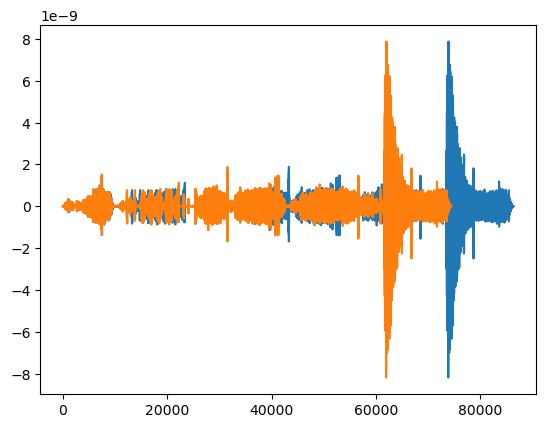

In [99]:
idx = 0
stream = train_streams[idx]
stream_cleaned = train_streams_cleaned[idx]
time_new = stream[0].times()[: len(stream_cleaned[1])]

trace = obspy.Trace(stream_cleaned[1])
trace.stats.starttime = obspy.UTCDateTime(time_new[0])
trace.stats.delta = time_new[1] - time_new[0]  # Set the sampling interval
trace.stats.npts = len(stream_cleaned[1])
stream_new = obspy.Stream(traces=[trace])


plt.plot(stream[0].times(), stream[0].data)
plt.plot(stream_new[0].times(), stream_new[0].data)
# plt.plot(time_new, stream_cleaned[1])
# plt.plot(stream_cleaned[0], stream_cleaned[1])
# plt.plot(stream[0].data)
# plt.plot(stream_cleaned[1])
plt.show()

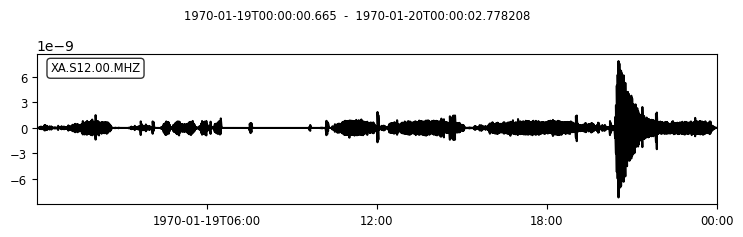

In [100]:
stream[0].plot()
plt.show()

In [101]:
stream_new[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T20:40:55.094340Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 493266
           calib: 1.0

## Scattering network


In [211]:
stream = train_streams[30]

In [212]:
stream_duration = stream[0].stats.endtime - stream[0].stats.starttime
# stream_duration = time_new[-1] - time_new[0]
sampling_frequency = stream[0].stats.sampling_rate
print(f"Stream duration: {stream_duration} seconds")
print(f"Sampling frequency: {sampling_frequency} Hz")

Stream duration: 86402.566038 seconds
Sampling frequency: 6.625 Hz


In [213]:
segment_duration_seconds = 350  # 302
sampling_rate_hertz = stream[0].stats.sampling_rate
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 10, "resolution": 2, "quality": 1},
    {"octaves": 6, "resolution": 1, "quality": 2},
)
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)
print(network)

ScatteringNetwork(bins=2318, sampling_rate=6.625, len=2)
ComplexMorletBank(bins=2318, octaves=10, resolution=2, quality=1, sampling_rate=6.625, len=20)
ComplexMorletBank(bins=2318, octaves=6, resolution=1, quality=2, sampling_rate=6.625, len=6)


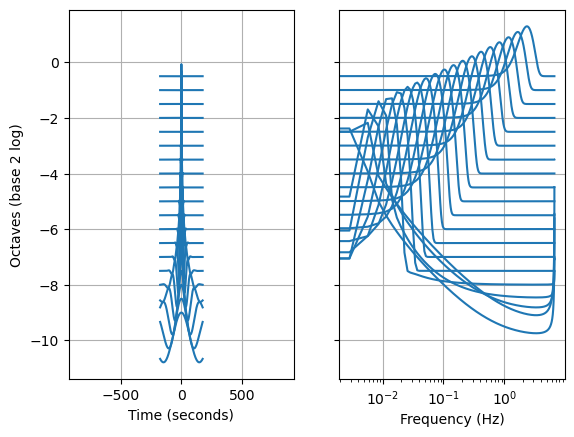

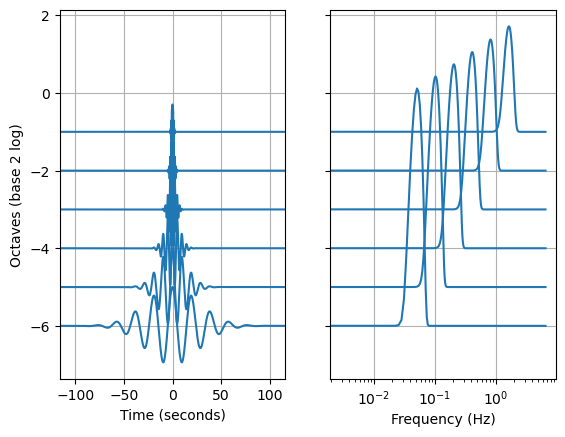

In [214]:
# Loop over network layers
for bank in network.banks:
    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(bank.wavelets, bank.spectra, bank.ratios):
        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[0].grid()
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].grid()

In [215]:
# Extract segment length (from any layer)
segment_duration_seconds = network.bins / network.sampling_rate
overlap = 0.5
print(f"Segment duration: {segment_duration_seconds} seconds")

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(
    segment_duration_seconds, segment_duration_seconds * overlap
):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

print(f"Number of segments: {len(segments)}")


Segment duration: 349.8867924528302 seconds
Number of segments: 492


In [216]:
network

ScatteringNetwork(bins=2318, sampling_rate=6.625, len=2)
ComplexMorletBank(bins=2318, octaves=10, resolution=2, quality=1, sampling_rate=6.625, len=20)
ComplexMorletBank(bins=2318, octaves=6, resolution=1, quality=2, sampling_rate=6.625, len=6)

In [217]:
scattering_coefficients = network.transform(segments, reduce_type=np.median)

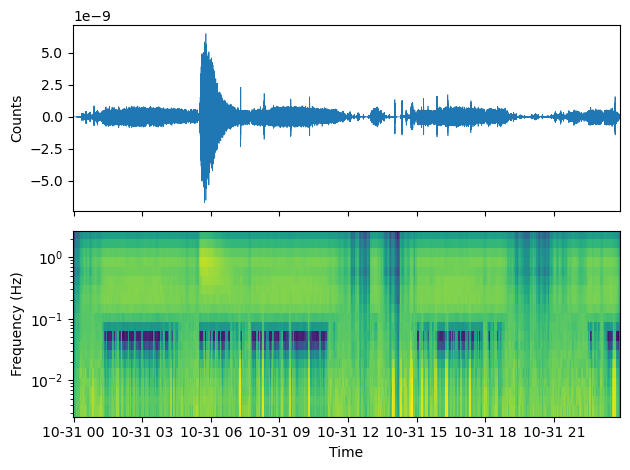

In [218]:
# Extract the first channel
channel_id = 0
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True)


# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# First-order scattering coefficients
im = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# Add colorbar
# cbar = fig.colorbar(im, ax=ax[1], label="Log10 Scattering Coefficients")

# Axes labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_xlabel("Time")

# Adjust layout and show
plt.tight_layout()
plt.show()

In [205]:
has_nan = np.isnan(scattering_coefficients[1]).any()
print(f"Contains NaN: {has_nan}")

Contains NaN: False


In [219]:
order_1 = scattering_coefficients[0]
order_2 = scattering_coefficients[1]
times = timestamps
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log10(scattering_coefficients)
times = np.array(times)


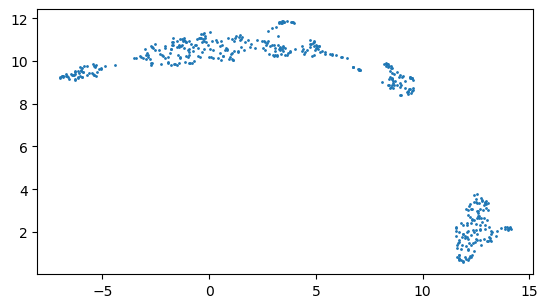

Number of clusters: 4


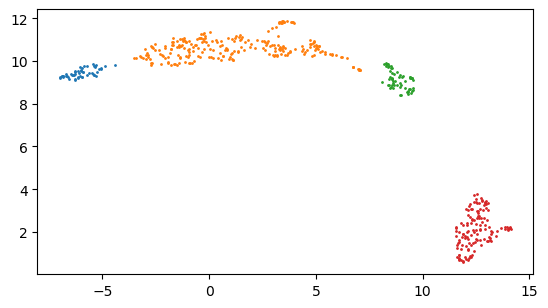

In [220]:
umap_model = umap.UMAP(n_components=2)
embedding = umap_model.fit_transform(scattering_coefficients)

# Visualize the UMAP results
fig, ax = plt.subplots()
ax.scatter(embedding[:, 0], embedding[:, 1], s=1)
ax.set_aspect("equal")
plt.show()
cluster_model = DBSCAN()
predictions = cluster_model.fit_predict(embedding)
N_CLUSTERS = len(np.unique(predictions))
print(f"Number of clusters: {N_CLUSTERS}")

# show clustering results in the atlas
fig, ax = plt.subplots()
for label in np.unique(predictions):
    where = label == predictions
    ax.scatter(embedding[where, 0], embedding[where, 1], s=1)
ax.set_aspect("equal")
plt.show()

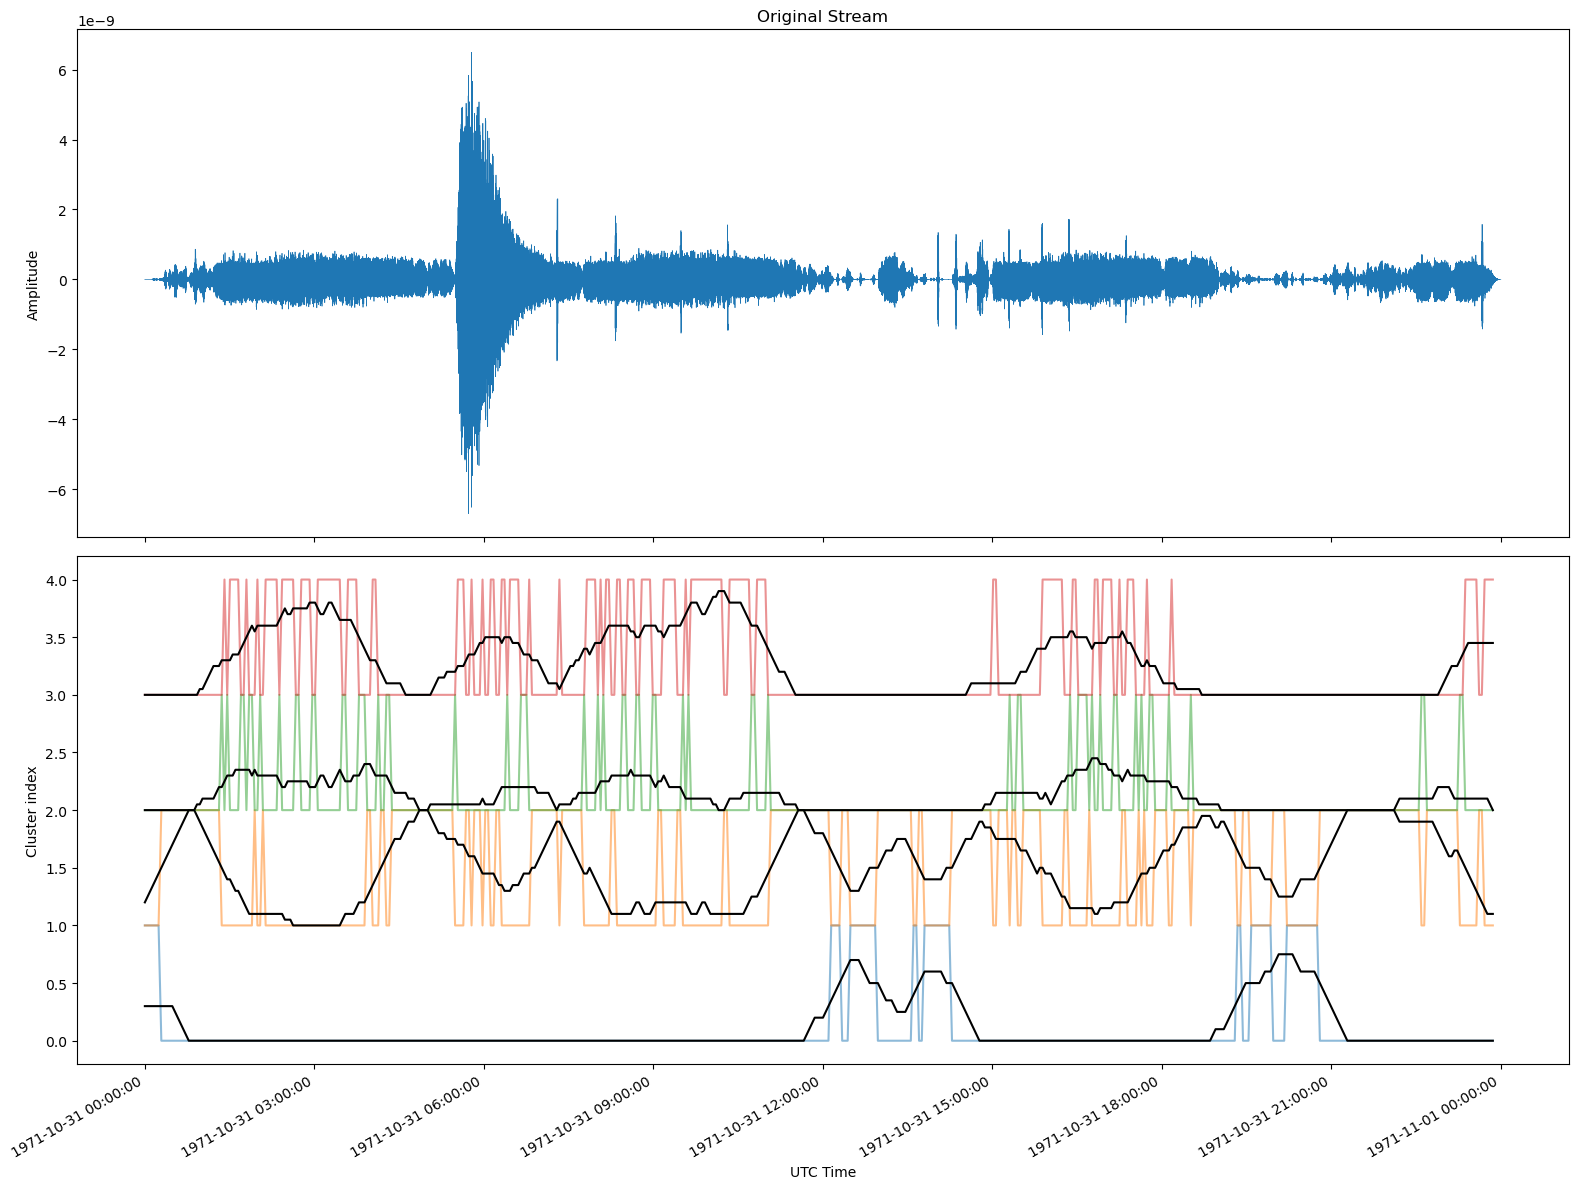

In [221]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Plot the stream in the upper subplot
ax1.plot(stream[0].times("matplotlib"), stream[0].data, linewidth=0.5)
ax1.set_ylabel("Amplitude")
ax1.set_title("Original Stream")

# Plot each cluster as a separate line in the lower subplot
for i in range(N_CLUSTERS):
    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = (
        np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL
    )

    # Plot the detection rate
    ax2.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax2.plot(times, detection_rate + i, color="black")

# Labels
ax2.set_xlabel("UTC Time")
ax2.set_ylabel("Cluster index")

# Set x-axis to display UTC datetime
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

plt.tight_layout()
plt.show()